In [13]:
from hcve_lib.splitting import train_test_fold
from hcve_lib.utils import notebook_init

notebook_init()

import pandas

from matplotlib import pyplot
from deps.logger import logger
from hcve_lib.tracking import get_completed_runs
from hcve_lib.tracking import is_root_run
from hcve_lib.tracking import get_children_runs
from deps.common import get_variables_cached
from mlflow import get_experiment_by_name
from hcve_lib.utils import split_data
import numpy as np
from hcve_lib.tracking import load_pickled_artifact
from hcve_lib.visualisation import b
import mlflow

logger.setLevel('DEBUG')
pandas.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
pyplot.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data, metadata, X, y = get_variables_cached()

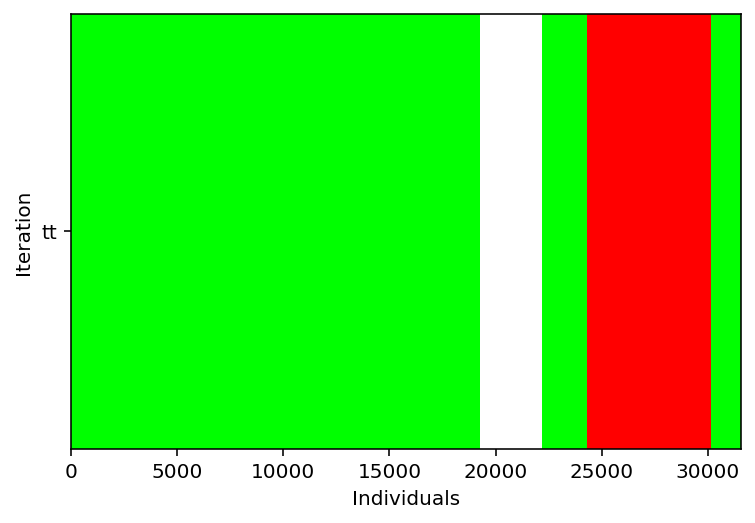

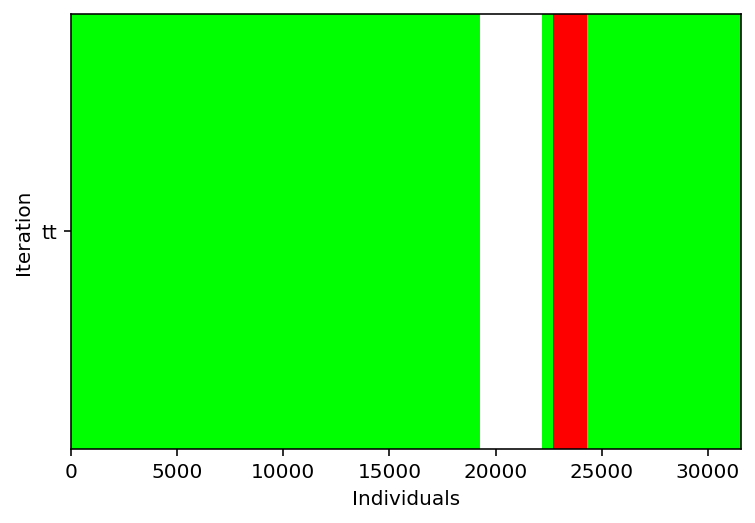

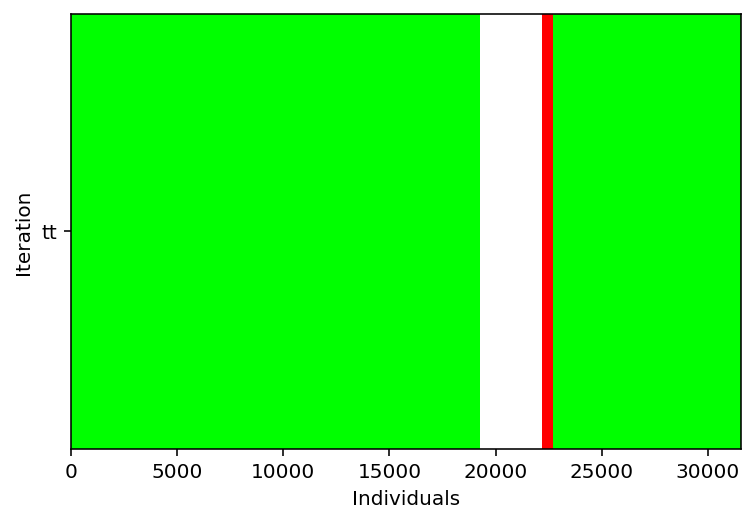

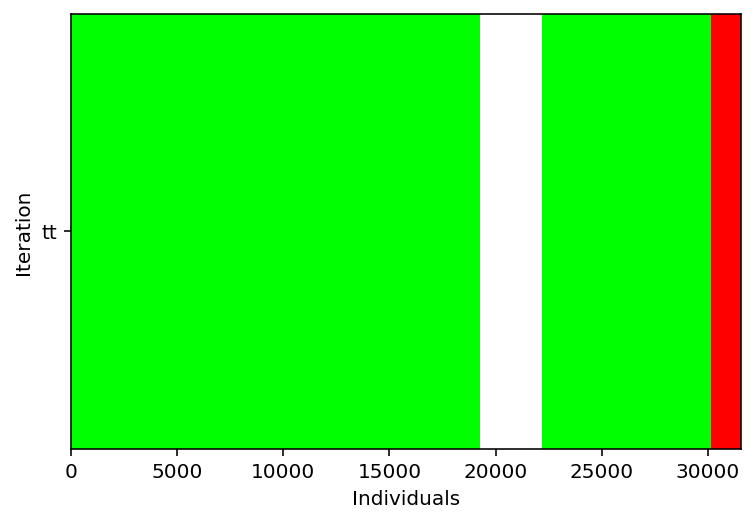

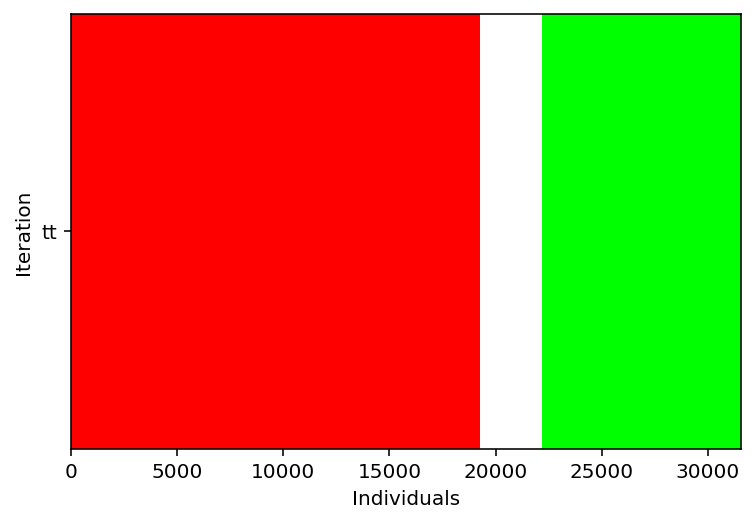

In [11]:
def plot_splits(result):
    X_all_index = data.index
    out = np.ones((len(result.keys()), len(X_all_index), 3), dtype='float')

    run_names = []
    for number, (name, fold) in enumerate(result.items()):
        row = X_all_index.to_numpy().copy()
        X_train, y_train, X_test, y_test = split_data(*train_test_fold(data, fold, metadata), fold)
        out[number][np.isin(row, X_train.index)] = (0,1,0)
        out[number][np.isin(row, X_test.index)] = (1,0,0)
        run_names.append(name)

    pyplot.imshow(out, aspect='auto', interpolation='none')
    pyplot.xlabel('Individuals')
    pyplot.yticks(ticks=list(range(len(run_names))), labels=run_names)
    pyplot.ylabel('Iteration')
    pyplot.show()

## Optimized LCO

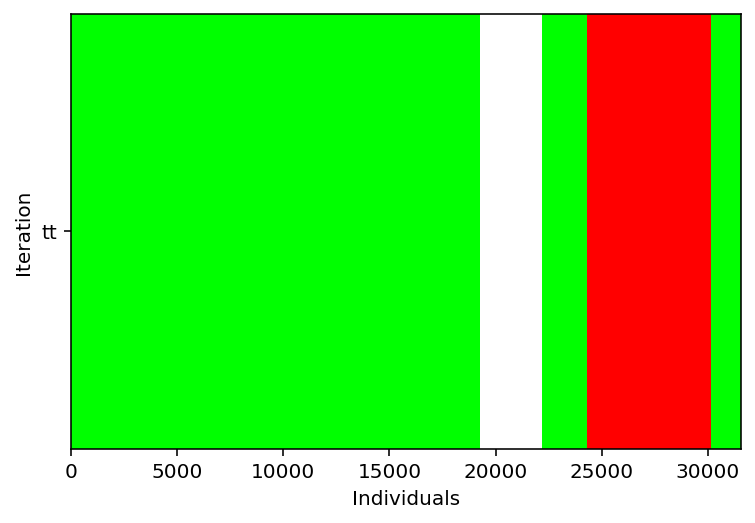

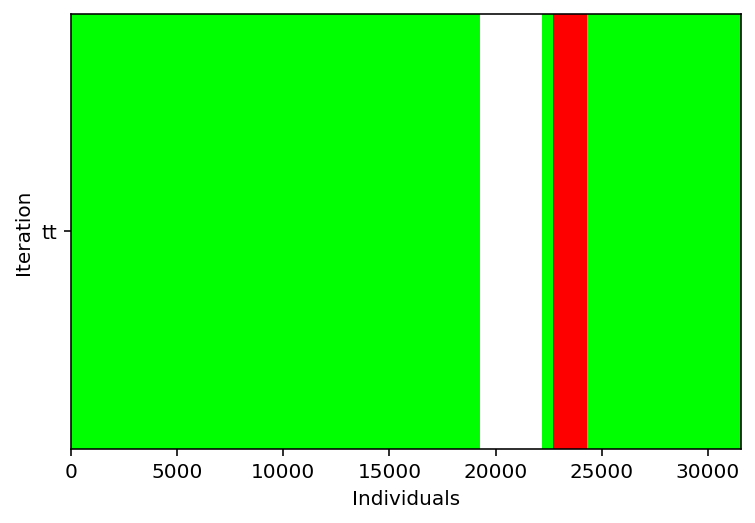

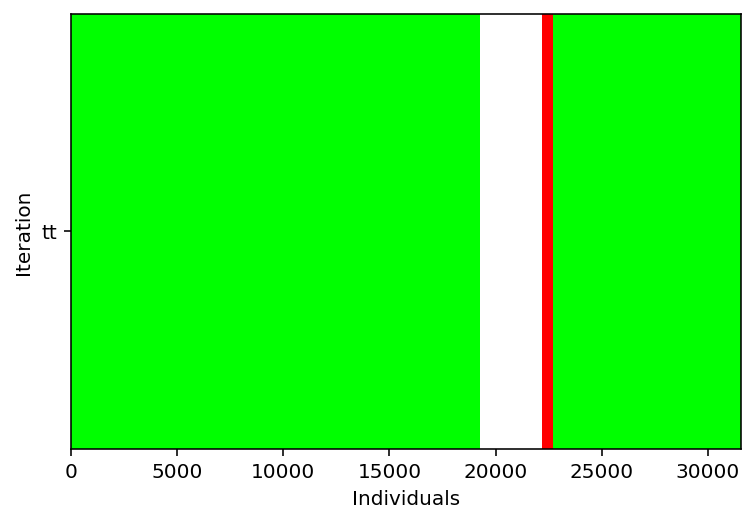

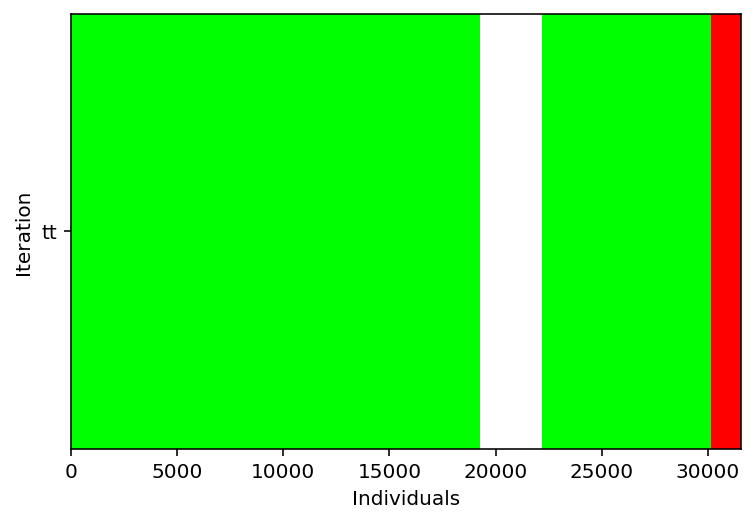

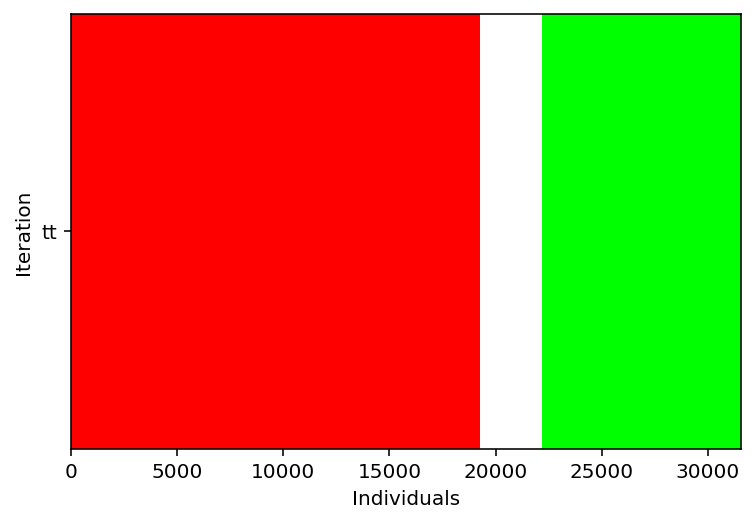

In [14]:
runs = mlflow.search_runs(
        get_experiment_by_name('optimized_lco').experiment_id)
last_root_run = runs[is_root_run(runs)].iloc[0]
nested_runs = get_children_runs(runs, last_root_run.run_id).iloc

for nested_run in nested_runs:
    b(nested_run['tags.mlflow.runName'])
    result = load_pickled_artifact(nested_run['run_id'], 'result')
    plot_splits(result)


## Optimized 10 fold per study

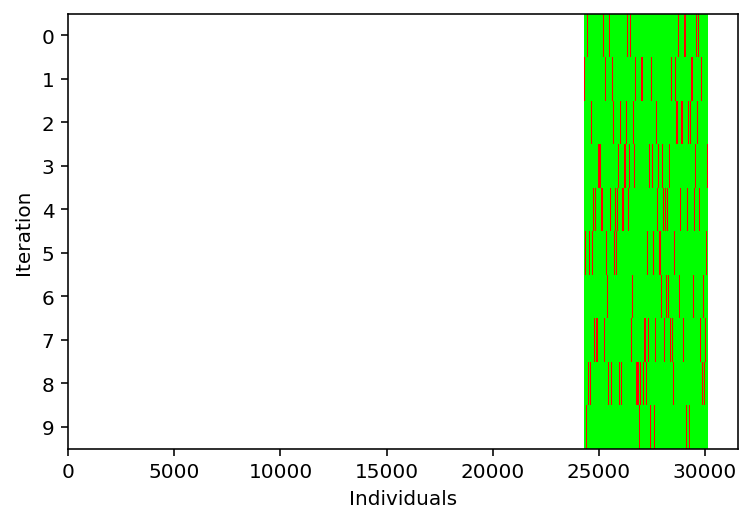

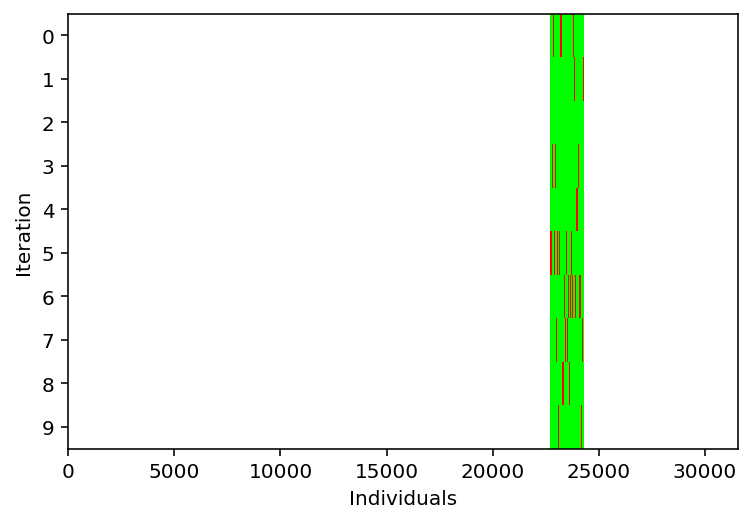

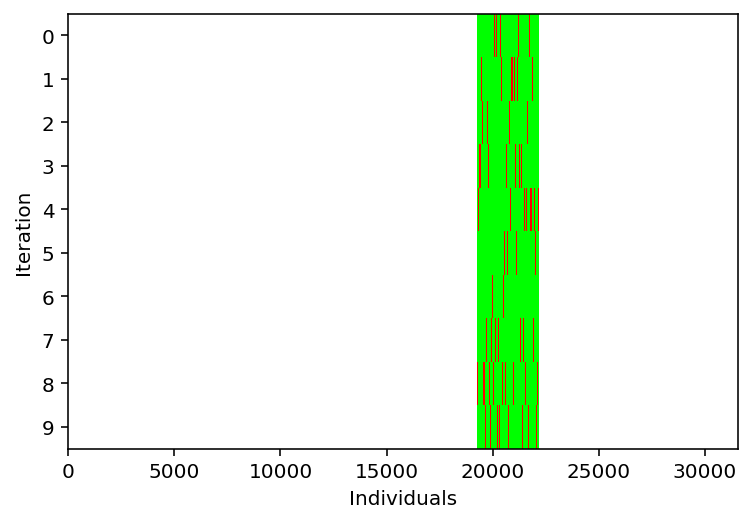

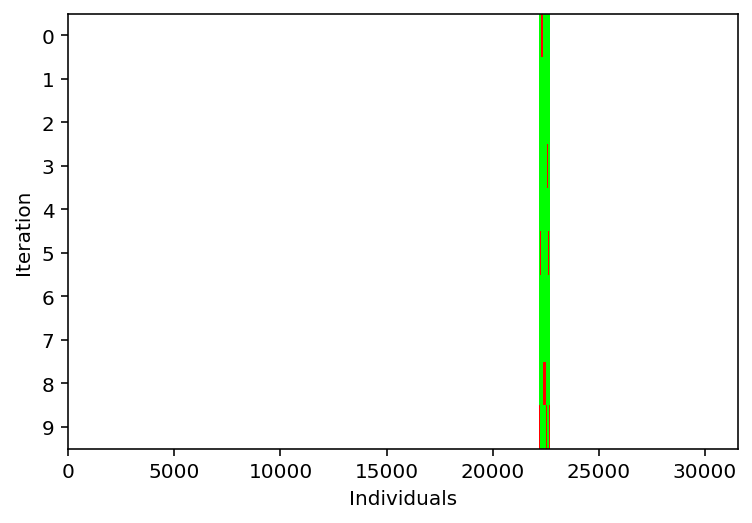

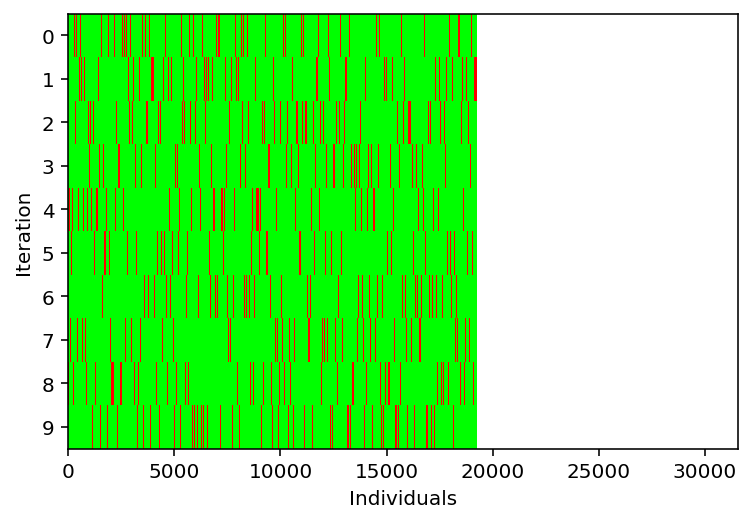

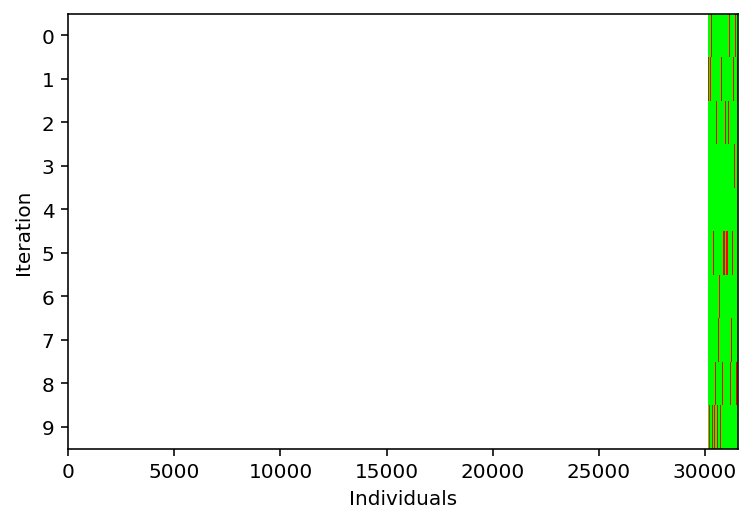

In [26]:
from hcve_lib.tracking import get_latest_root_run

runs = get_completed_runs('optimized_10_fold_per_study')
last_root_run = get_latest_root_run(runs)
nested_runs = get_children_runs(runs, last_root_run.run_id)

for _, nested_run in nested_runs.iterrows():
    b(nested_run['tags.mlflow.runName'])
    last_result = load_pickled_artifact(nested_run['run_id'], 'result')
    plot_splits(last_result)